In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

from nltk.tokenize import word_tokenize

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from scipy.sparse import csr_matrix

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from numpy import array, argmax

In [70]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

embed_num_dims = 300
max_seq_len = 500
class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [74]:
data_train = pd.read_csv('Data/Train_data.csv', encoding='utf-8')
data_test = pd.read_csv('Data/Test_data.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [75]:
print(data.Emotion.value_counts())
data.head(6)

joy        15027
sadness    13307
anger       6924
fear        6162
neutral     3654
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


In [76]:
#Dropping Null Values

data = data.dropna()

<AxesSubplot:xlabel='Emotion', ylabel='count'>

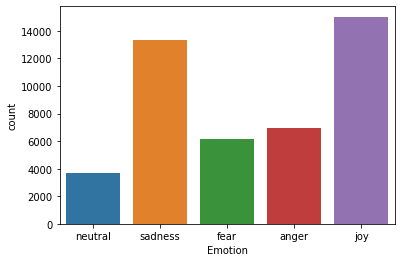

In [78]:
df = data[data['Emotion'].isin(class_names)]

sns.countplot(x = 'Emotion',data = data)

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Preparing Data

In [27]:
lemmetize = WordNetLemmatizer()
def data_prep(data):

    data = re.sub('[^a-zA-Z]',' ',data)
    data = data.lower()
    data = word_tokenize(data)
    
    #print(data)
    return [lemmetize.lemmatize(word) for word in data if word not in set(stopwords.words('english'))]
        

In [28]:
texts = [' '.join(data_prep(text)) for text in df.Text]

texts_train = [' '.join(data_prep(text)) for text in X_train]
texts_test = [' '.join(data_prep(text)) for text in X_test]

In [29]:
print(texts_train[92])

bit extremely annoyed phone promised would liar


### Tokenization


In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index


vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 7742


In [32]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad
X_test_pad

array([[   0,    0,    0, ...,  341,   55,   30],
       [   0,    0,    0, ...,   90,  593, 5446],
       [   0,    0,    0, ...,  192,  240,  365],
       ...,
       [   0,    0,    0, ...,    0,    0,   96],
       [   0,    0,    0, ..., 7742,   46,   34],
       [   0,    0,    0, ..., 1477,    2,  437]])

In [34]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train1 = [encoding[x] for x in y_train]#data_train.Emotion]
y_test1 = [encoding[x] for x in y_test]#data_test.Emotion]


### 2. Importing pre trained word vector



In [36]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [37]:
#file = open(fname, encoding="cp1252")
fname = 'embeddings/wiki-news-300d-1M.vec'
file = open(fname, encoding="utf8")

embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(7743, 300)

In [38]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 7319
New words found: 423


### 3. Creating LSTM Pipeline

In [39]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [40]:

# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [57]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          2322900   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 2,654,425
Trainable params: 331,525
Non-trainable params: 2,322,900
_________________________________________________________________


### 3. Train model

+ validation data: use validation_split in order to estimate how well your model has been trained and adjust parameters or add dropout layers. After that we will train the model using the complete train set.
+ epochs: 15 batch_size: 128

In [55]:
#y_train1.shape

#newarr = y_train1.reshape(len(y_train1), )
print(X_train_pad.shape)
print(X_test_pad.shape)

print(type(y_train1))
y_train1 = np.array(y_train1)
y_test1 = np.array(y_test1)
#print(type(arr))

(2617, 500)
(3393, 500)
<class 'list'>


In [58]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train1, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad,y_test1))

Epoch 1/15
21/21 [==============================] - 539s 26s/step - loss: 1.5297 - accuracy: 0.3504 - val_loss: 1.4200 - val_accuracy: 0.4604
Epoch 2/15
21/21 [==============================] - 491s 23s/step - loss: 1.3342 - accuracy: 0.4765 - val_loss: 1.2787 - val_accuracy: 0.4966
Epoch 3/15
21/21 [==============================] - 881s 43s/step - loss: 1.1691 - accuracy: 0.5674 - val_loss: 1.1177 - val_accuracy: 0.5889
Epoch 4/15
21/21 [==============================] - 998s 48s/step - loss: 1.0084 - accuracy: 0.6236 - val_loss: 0.9967 - val_accuracy: 0.6357
Epoch 5/15
21/21 [==============================] - 1086s 52s/step - loss: 0.9044 - accuracy: 0.6584 - val_loss: 0.9509 - val_accuracy: 0.6502
Epoch 6/15
21/21 [==============================] - 1043s 50s/step - loss: 0.8450 - accuracy: 0.6905 - val_loss: 0.9197 - val_accuracy: 0.6605
Epoch 7/15
21/21 [==============================] - 1290s 62s/step - loss: 0.7967 - accuracy: 0.7073 - val_loss: 0.9018 - val_accuracy: 0.6755
Epo

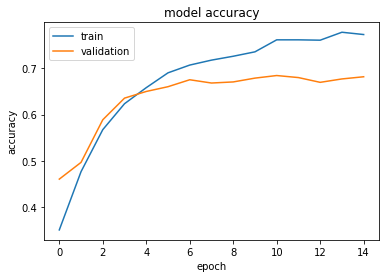

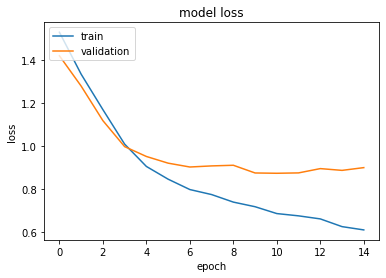

In [61]:

#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluation

In [62]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [63]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 68.20%

F1 Score: 68.20


### Testing

In [64]:

print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: anger


In [80]:
message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} '.format(class_names[np.argmax(pred)]))

Message: ['delivery was hour late and my pizza was cold!']
predicted: anger 


### 5. Saving the model

In [81]:
# creates a HDF5 file 'my_model.h5'
model.save('LSTM_model.h5')